# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
## Imports

In [1]:
import graphlab
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
graphlab.canvas.set_target('ipynb')

A newer version of GraphLab Create (v1.10) is available! Your current version is v1.9.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.
2016-06-08 16:20:10,081 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1465417208.log


This non-commercial license of GraphLab Create is assigned to damiansp@gmail.com and will expire on March 07, 2017. For commercial licensing options, visit https://dato.com/buy/.


# Load amazon review dataset

In [2]:
products = graphlab.SFrame('amazon_baby.gl/')

# Extract word counts and sentiments

As in the first notebook in this directory, compute the word counts for individual words and extract positive and negative sentiments from ratings:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [3]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words
products['word_count'] = graphlab.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to 1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : 1 if rating > 3 else -1)

Examine:

In [4]:
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'and': 3, 'love': 1,'it': 3, 'highly': 1, ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'and': 2, 'quilt': 1,'it': 1, 'comfortable': ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'and': 3, 'ingenious':1, 'love': 2, 'what': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'and': 2, 'all': 2,'help': 1, 'cried': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'and': 2, 'this': 2,'her': 1, 'help': 2, ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'shop': 1, 'noble': 1,'is': 1, 'it': 1, 'as': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'and': 2, 'all': 1,'right': 1, 'had': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'and': 1, 'fantastic':1, 'help': 1, 'give': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'all': 1, 'standarad':1, 'another': 1, 'when': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'all': 2, 'nannys': 1,'just': 1, 'food': 1, ...",1


## Split data into training and test sets

In [5]:
train_data, test_data = products.random_split(0.8, seed = 1)

## Train a logistic regression classifier

Train a logistic regression classifier with **sentiment** as the target and **word_count** as the features. 

In [6]:
model = graphlab.logistic_classifier.create(
    train_data, target = 'sentiment',features = ['word_count'], validation_set = None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 121712

Number of coefficients    : 121713

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 1         | 5        | 0.000002  | 2.143997     | 0.840754          |

| 2         | 9        | 3.000000  | 3.210527     | 0.931350          |

| 3         | 10       | 3.000000  | 3.598036     | 0.882046          |

| 4         | 11       | 3.000000  | 3.986385     | 0.954076          |

| 5         | 12       | 3.000000  | 4.379967     | 0.960964          |

| 6         | 13       | 3.000000  | 4.780659     | 0.975033          |

+-----------+----------+-----------+--------------+-------------------+

TERMINATED: Terminated due to numerical difficulties.

This model may not be ideal. To improve it, consider doing one of the following:
(a) Increasing the regularization.
(b) Standardizing the input data.
(c) Removing highly correlated features.
(d) Removing `inf` and `NaN` values in the training data.

# Model Evaluation

## Accuracy

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

In [7]:
accuracy = model.evaluate(test_data, metric = 'accuracy')['accuracy']
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.914536837053


## Baseline: Majority class prediction

An earlier notebook used the **majority class classifier** as a baseline model for a point of comparison with more sophisticated classifiers. The majority classifier model predicts the majority class for all data points. 

Any good model should beat the majority class classifier. Since the majority class in this data set is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [8]:
baseline = len(test_data[test_data['sentiment'] == 1]) / len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


## Confusion Matrix

Accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```

In [9]:
confusion_matrix = model.evaluate(test_data, metric = 'confusion_matrix')['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,-1,1406
-1,-1,3798
-1,1,1443
1,1,26689


In [10]:
# Formatted as the confusion matrix above (with marginals added):
#       1     -1    marg
# 1 26689   1406   28095
#-1  1443   3798    5241
# m 28132   5204   33336

## Computing the cost of mistakes

Suppose you are a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [11]:
fp_c = 100
fn_c = 1
fp_n = 1443
fn_n = 1406
print 'Cost: $%d' %(fp_c * fp_n + fn_c * fn_n)

Cost: $145706


## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, compute the precision of the logistic regression classifier on the **test_data**.

In [12]:
precision = model.evaluate(test_data, metric = 'precision')['precision']
print "Precision on test data: %s" % precision

Precision on test data: 0.948706099815


Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [13]:
tp_n = 26689
print fp_n / (fp_n + tp_n)
# Same as
print 1 - precision

0.0512939001848
0.0512939001848


A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Compute the recall on the **test_data**.

In [15]:
recall = model.evaluate(test_data, metric = 'recall')['recall']
print "Recall on test data: %s" % recall
# Same as:
print 'Recall:', tp_n / (tp_n + fn_n)
tn_n = 3798
print 'Recall for majority classifier:', (tp_n + fn_n) / (tp_n + fn_n + tn_n + fp_n), 'same as', 28095 / (28095 + 5241)

Recall on test data: 0.949955508098
Recall: 0.949955508098
Recall for majority classifier: 0.842782577394 same as 0.842782577394


# Precision-recall tradeoff

Explore the trade-off between precision and recall.  First examine what happens when using a different threshold value for making class predictions.  Then explore a range of threshold values and plot the associated precision-recall curve.  

## Varying the threshold

False positives are costly in the above example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Function `apply_threshold` accepts:
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

Returns an array, where each element is set to 1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [16]:
def apply_threshold(probabilities, threshold):
    # +1 if >= threshold and -1 otherwise.
    return graphlab.SArray([1 if p >= threshold else -1 for p in probabilities])

# test
#probs = [0., 0.25, 0.5, 0.75, 1]
#thresh = 0.8
#apply_threshold(probs, thresh)

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [19]:
probabilities = model.predict(test_data, output_type = 'probability')
print 'p(1):', probabilities[:10]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
print '0.5 threshold:', predictions_with_default_threshold[:10]
print 'n "1":', sum([p == 1 for p in predictions_with_default_threshold[:10]])

predictions_with_high_threshold = apply_threshold(probabilities, 0.9)
print '0.9 threshold:', predictions_with_high_threshold[:10]
print 'n "1":', sum([p == 1 for p in predictions_with_high_threshold[:10]])

p(1): [0.758399887751921, 0.9999999999664292, 0.22895097808041293, 0.9999995580631229, 0.9905421692480326, 0.9999992959681095, 0.9997644762803488, 0.7228344662830163, 0.9992668408960913, 0.9997868300478302]
0.5 threshold: [1, 1, -1, 1, 1, 1, 1, 1, 1, 1]
n "1": 9
0.9 threshold: [-1, 1, -1, 1, 1, 1, 1, -1, 1, 1]
n "1": 7


In [20]:
print("Number of positive predicted reviews (threshold = 0.5): %s" 
      %sum([p == 1 for p in predictions_with_default_threshold]))

Number of positive predicted reviews (threshold = 0.5): 28132


In [21]:
print("Number of positive predicted reviews (threshold = 0.9): %s" 
      %sum([p == 1 for p in predictions_with_high_threshold]))

Number of positive predicted reviews (threshold = 0.9): 25630


## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. Explore:

In [22]:
# Threshold = 0.5
precision_with_default_threshold = graphlab.evaluation.precision(
    test_data['sentiment'], predictions_with_default_threshold)
recall_with_default_threshold = graphlab.evaluation.recall(
    test_data['sentiment'], predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = graphlab.evaluation.precision(
    test_data['sentiment'], predictions_with_high_threshold)
recall_with_high_threshold = graphlab.evaluation.recall(
    test_data['sentiment'], predictions_with_high_threshold)

In [23]:
print "Precision (threshold = 0.5): %s" %precision_with_default_threshold
print "Recall (threshold = 0.5)   : %s" %recall_with_default_threshold

Precision (threshold = 0.5): 0.948706099815
Recall (threshold = 0.5)   : 0.949955508098


In [24]:
print "Precision (threshold = 0.9): %s" %precision_with_high_threshold
print "Recall (threshold = 0.9)   : %s" %recall_with_high_threshold

Precision (threshold = 0.9): 0.969527896996
Recall (threshold = 0.9)   : 0.884463427656


## Precision-recall curve

Explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [25]:
threshold_values = np.linspace(0.5, 1, num = 100)

For each of the values of threshold, compute the precision and recall scores.

In [26]:
precision_all = []
recall_all = []

probabilities = model.predict(test_data, output_type = 'probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = graphlab.evaluation.precision(test_data['sentiment'], predictions)
    recall = graphlab.evaluation.recall(test_data['sentiment'], predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Plot the precision-recall curve to visualize the precision-recall tradeoff as threshold varies.

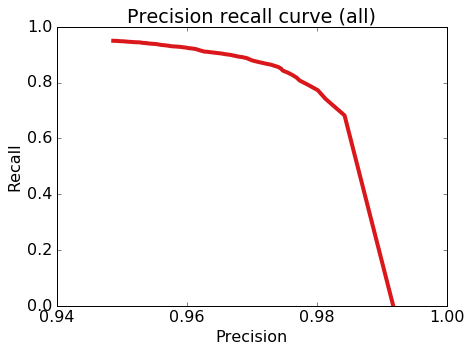

In [28]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth = 4.0, color = '#DA171A')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({ 'font.size': 16 })
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [29]:
for (p, t) in zip(precision_all, threshold_values):
    print p, t

0.948706099815 0.5
0.94905908719 0.505050505051
0.949288256228 0.510101010101
0.949506819072 0.515151515152
0.949624140511 0.520202020202
0.949805711026 0.525252525253
0.950203324534 0.530303030303
0.950417648319 0.535353535354
0.950696677385 0.540404040404
0.950877694755 0.545454545455
0.951062459755 0.550505050505
0.951424684994 0.555555555556
0.951534907046 0.560606060606
0.951761459341 0.565656565657
0.952177656598 0.570707070707
0.952541642734 0.575757575758
0.952825782345 0.580808080808
0.952950902164 0.585858585859
0.953033408854 0.590909090909
0.953081711222 0.59595959596
0.953231323132 0.60101010101
0.953525236877 0.606060606061
0.953680340278 0.611111111111
0.953691347784 0.616161616162
0.954012200845 0.621212121212
0.95415959253 0.626262626263
0.954481362305 0.631313131313
0.954630969609 0.636363636364
0.954956912159 0.641414141414
0.955217391304 0.646464646465
0.955425794284 0.651515151515
0.955603150978 0.656565656566
0.955716205907 0.661616161616
0.955933682373 0.66666666

Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**?

In [30]:
graphlab.evaluation.confusion_matrix(test_data['sentiment'], apply_threshold(probabilities, threshold = 0.98))
# FN = 5826

target_label,predicted_label,count
-1,1,487
1,1,22269
1,-1,5826
-1,-1,4754


This is the number of false negatives (i.e., the number of reviews to look at when not needed) that we have to deal with using this classifier.

# Evaluating specific search terms

Select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [31]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Predict the probability of classifying these reviews as positive:

In [32]:
probabilities = model.predict(baby_reviews, output_type = 'probability')

Plot the precision-recall curve for the **baby_reviews** dataset.

**First**, consider `threshold_values` ranging from 0.5 to 1:

In [33]:
threshold_values = np.linspace(0.5, 1, num = 100)

**Second**, as above, compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset.

In [34]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    # Make predictions. Use the `apply_threshold` function 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision and recall.
    precision = graphlab.evaluation.precision(baby_reviews['sentiment'], predictions)
    recall = graphlab.evaluation.recall(baby_reviews['sentiment'], predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

In [35]:
for (p, t) in zip(precision_all, threshold_values):
    print p, t

0.947656392486 0.5
0.948165723672 0.505050505051
0.948319941563 0.510101010101
0.948474328522 0.515151515152
0.948638274538 0.520202020202
0.948792977323 0.525252525253
0.949487554905 0.530303030303
0.949459805896 0.535353535354
0.94998167827 0.540404040404
0.949954170486 0.545454545455
0.95011920044 0.550505050505
0.950816663608 0.555555555556
0.95080763583 0.560606060606
0.950964187328 0.565656565657
0.951793928243 0.570707070707
0.951951399116 0.575757575758
0.952082565426 0.580808080808
0.952407304925 0.585858585859
0.952363367799 0.590909090909
0.952345770225 0.59595959596
0.952336966562 0.60101010101
0.952856350527 0.606060606061
0.95282146161 0.611111111111
0.952795261014 0.616161616162
0.952901909883 0.621212121212
0.953035084463 0.626262626263
0.953212031192 0.631313131313
0.953354395094 0.636363636364
0.953683035714 0.641414141414
0.954020848846 0.646464646465
0.954172876304 0.651515151515
0.954164337619 0.656565656566
0.954291044776 0.661616161616
0.954248366013 0.6666666666

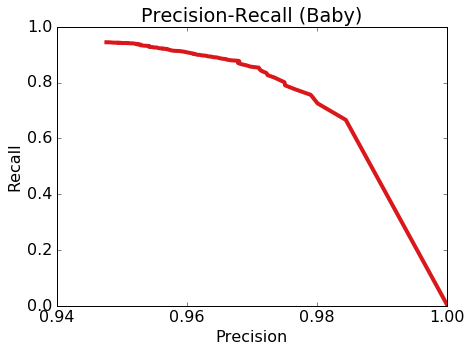

In [36]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")